In [1]:
from _utils import *
from scipy.stats import qmc

def calculate_conformational_variance_jax(dmap_list, dmap_ref):
    """
    Calculate the conformational variation of a set of distance maps relative to a reference map.

    Parameters:
    dmap_list (list): A list of 2D numpy arrays representing the distance maps.
    dmap_ref (np.ndarray): A 2D numpy array representing the reference distance map.
    num_probes (int): The number of probes in the distance maps.

    Returns:
    np.ndarray: A 2D numpy array containing the variance of the squared Euclidean distances 
               between each distance map and the reference map.
    """
    # Convert dmap_list to a NumPy array
    dmap_list = jnp.array(dmap_list)
    
    # Calculate the squared Euclidean distance between each distance map and the reference map
    diff_list = jnp.sqrt((dmap_list - dmap_ref) ** 2) 
    
    # Calculate the variance along the number of observation/cell dimension
    var = jnp.var(diff_list, axis=0)
    
    return var


# Rewrite this in a jax-compatible fashion
from functools import partial
@partial(jax.jit, static_argnums=(2,)) 
def batch_calculate_variances(dmap_list, dmap_ref, num_probes):
    """
    Vectorized version that applies calculate_conformational_variance_jax across a batch of distance maps.
    """
    return jax.vmap(lambda dmap: calculate_conformational_variance_jax(dmap_list, jnp.reshape(dmap, [num_probes, num_probes])))(dmap_ref)


# Define the main loglikelihood function using JAX
def loglikelihood_jax(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    return jnp.sum(_loglikelihood_jax(dmap_flat, ref_dmap_flat, measurement_error, num_probes))


# Define the helper function, with JAX-compatible logic
def _loglikelihood_jax(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    # Use lax.cond for control flow based on the condition
    min_value = jnp.iinfo(jnp.int32).min
    
    def handle_invalid_reference(ref_dmap_flat):
        # Return extremely low probability when ref_dmap_flat contains invalid values
        return jnp.array([jnp.float32(min_value), jnp.float32(min_value)])
    
    def handle_valid_reference(ref_dmap_flat):
        # Calculate the difference between distance map and reference 
        subtraction_map_sq = jnp.square(dmap_flat - ref_dmap_flat).reshape(num_probes, num_probes)

        # Only consider the upper triangular part of the distance map
        # because the diagonal values do not have variance
        triu_indices = jnp.triu_indices(num_probes, k=1)
        measurement_error_scaled = 2 * measurement_error[triu_indices]  # both triangles 
        subtraction_map_sq_scaled = 2 * subtraction_map_sq[triu_indices]  # both triangles
        
        # Calculate the normalization factor
        normalization_factor = -jnp.sum(jnp.log(jnp.sqrt(2 * jnp.pi * measurement_error_scaled**2)))
        
        # Calculate the Gaussian term 
        gaussian_term = -jnp.sum(subtraction_map_sq_scaled / (2 * jnp.square(measurement_error_scaled)))
        
        return jnp.array([normalization_factor, gaussian_term])

    # Apply the appropriate logic depending on whether ref_dmap_flat contains negative values
    return lax.cond(
        jnp.any(ref_dmap_flat <= -1),
        handle_invalid_reference,
        handle_valid_reference,
        ref_dmap_flat
    )
    
def compute_loglikelihood_for_y(y, templates_flatten, measurement_error_esc, num_probes):
    return jax.vmap(lambda x, z: loglikelihood_jax(y, x, z, num_probes))(templates_flatten, measurement_error_esc)


folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

def calculate_distance_map(polys):
    # Extract the dimensions of the input array
    num_probes, num_coords, num_cells = polys.shape
    
    # Initialize an array of the same shape to hold the interpolated values
    new_maps = np.zeros((num_cells, num_probes, num_probes))
    
    # Iterate over each cell
    for c in range(num_cells):
        # Extract the data for the current cell
        curr_cells = polys[:, :, c]
        
        # Skip cells with all missing values
        if np.all(np.isnan(curr_cells)):
            continue  # This leaves a matrix of zeros in the output array
        
        # Calculate the pairwise Euclidean distance between each pair of probes
        dmap = squareform(pdist(curr_cells))
        
        # Assign the distance map to the corresponding position in the output array
        new_maps[c, :, :] = dmap
    
    # Return the array with interpolated values
    return new_maps

esc_maps_interp = calculate_distance_map(esc_polys_interp)
cnc_maps_interp = calculate_distance_map(cnc_polys_interp)
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)


2024-10-16 21:10:25.327209: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 21:10:25.368848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
pca = PCA(n_components=None)  # Change here for the number of dimensions
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

all_maps_pca = np.concatenate((esc_maps_pca, cnc_maps_pca), axis=0)

# Use Latin Hypercube sampling to generate 1000 samples
# This technique tries to sample data points in a way that they are evenly distributed

num_microstates = 1000
num_dimension = pca.n_components_ # pca.n_components_

sampler = qmc.LatinHypercube(d=num_dimension)
sample = sampler.random(n=num_microstates)

# We can use quantiles to get physical bounds
l_quantile = 0.01
u_quantile = 1 - l_quantile
l_bounds = np.quantile(all_maps_pca, l_quantile, axis=0)
u_bounds = np.quantile(all_maps_pca, u_quantile, axis=0)
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

# Add these sample_scaled coordinates to a dataframe
sample_df = pd.DataFrame(sample_scaled, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Inverse transform the samples
microstates_maps = pca.inverse_transform(sample_scaled)


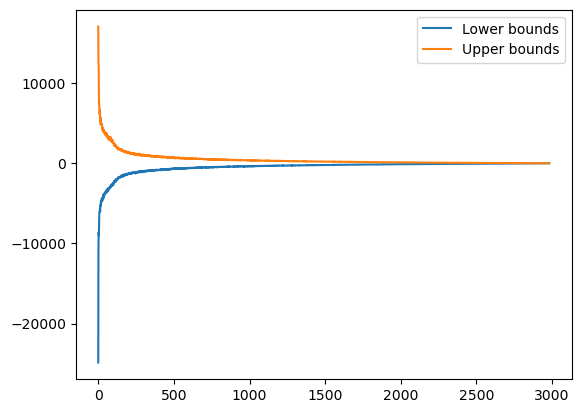

In [17]:
plt.plot(l_bounds, label='Lower bounds')
plt.plot(u_bounds, label='Upper bounds')
plt.legend()

In [7]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))  # This prevents crash on GPU

[]


2024-10-16 21:12:39.148011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
microstates_maps_jax = jnp.array(microstates_maps)
esc_std = batch_calculate_variances(jnp.array(esc_maps_interp), microstates_maps_jax, num_monomers)**0.5
cnc_std = batch_calculate_variances(jnp.array(cnc_maps_interp), microstates_maps_jax, num_monomers)**0.5

2024-10-16 21:12:40.850893: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
lpm = [(logprior(x, num_monomers)).tolist() for x in microstates_maps]

In [69]:
len(lpm)

1000

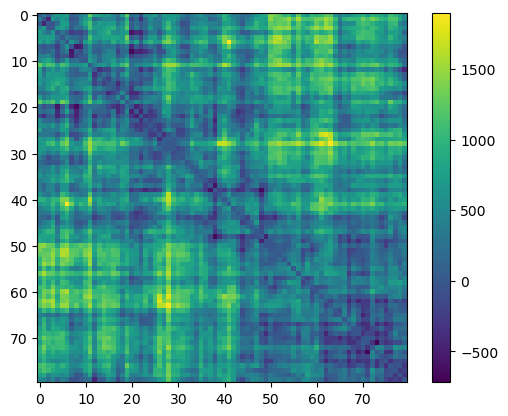

In [13]:
plt.imshow(microstates_maps[0].reshape(num_monomers, num_monomers))
plt.colorbar()

In [10]:
lpm

[-4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294967296,
 -4294

In [70]:
esc_ll = [compute_loglikelihood_for_y(y, microstates_maps_jax, esc_std, num_monomers) for y in tqdm(esc_maps_interp_flat)]
cnc_ll = [compute_loglikelihood_for_y(y, microstates_maps_jax, cnc_std, num_monomers) for y in tqdm(cnc_maps_interp_flat)]

  0%|          | 0/1225 [00:00<?, ?it/s]

  0%|          | 0/1757 [00:00<?, ?it/s]

In [71]:
np.array(esc_ll).shape

(1225, 1000)

In [72]:
esc_ll = [x.tolist() for x in esc_ll]
cnc_ll = [x.tolist() for x in cnc_ll]

N_esc = esc_maps_interp_flat.shape[0]
N_cnc = cnc_maps_interp_flat.shape[0]

M = num_microstates

my_model = CmdStanModel(
    stan_file='/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/stan/20240715_WeightOptimization.stan',
    cpp_options = {
        "STAN_THREADS": True,
    }
    )

n_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {n_cores}")
parallel_chains = 4
threads_per_chain = int(n_cores / parallel_chains)
print(f"Number of threads per chain: {threads_per_chain}")

Number of CPU cores: 64
Number of threads per chain: 16


In [73]:
M

1000

In [74]:
save_dir = f'/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightMCMC_Sox9_PCA_LatinCubeSampling_10000_Rank{num_dimension}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# save sample df to save_dir
sample_df.to_csv(os.path.join(save_dir, 'sampled_microstates.csv'), index=False)

conditions = [
    'ESC', 'CNC'
]

for condition in tqdm(conditions):
    output_dir = os.path.join(save_dir, condition)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    json_filename = os.path.join(output_dir, 'data.json')
    stan_putput_file = os.path.join(output_dir, 'stan_output')
    
    if condition == 'ESC':
        data_dict = {
            'N': N_esc,
            'M': M,
            'll_map': esc_ll,
            'lpm_vec': lpm,
        }
    
    elif condition == 'CNC':
        data_dict = {
            'N': N_cnc,
            'M': M,
            'll_map': cnc_ll,
            'lpm_vec': lpm,
        }
        
    json_obj = json.dumps(data_dict, indent=4)
    
    with open(json_filename, 'w') as json_file:
        json_file.write(json_obj)
        json_file.close()

  0%|          | 0/2 [00:00<?, ?it/s]

In [75]:
def submit_mcmc_slurm(mcmc_common_dir, slurm_file):
    # List all the directories in the MCMC common directory
    # Only return directories that contain data.json
    dirs = []

    # List all items in the current directory
    for item in os.listdir(mcmc_common_dir):
        # Get the full path of the item
        full_path = os.path.join(mcmc_common_dir, item)
        
        # Check if the item is a directory
        # And if the directory contains data.json
        # Check if 'data.json' exists in the directory
        file_path = os.path.join(full_path, 'data.json')
        if os.path.isfile(file_path):
            dirs.append(full_path)
            
    # Submit a slurm job for each directory
    for dir in dirs:
        # Get the name of the directory
        
        dir_name = os.path.basename(dir)
        print(f"Submitting slurm job for {dir_name}")
        
        run_mcmc_py = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/_run_mcmc.py'
        
        # Submit a slurm job
        cmd = f'sbatch {slurm_file} {run_mcmc_py} {dir}'
        
        # Run the command
        os.system(cmd)

In [76]:
slurm_file = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/slurm/2024_RunPythonScript.sh'

In [77]:
submit_mcmc_slurm(save_dir, slurm_file)

Submitting slurm job for ESC
Submitted batch job 4063387
Submitting slurm job for CNC
Submitted batch job 4063388
